In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import cv2 as cv
import math
import sklearn.metrics
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import gaussian
from skimage.segmentation import chan_vese
import time
import csv
import pandas as pd

In [ ]:
imgs = {"1.jpg":27, "2.jpg":10, "3.jpg":9, "4_old.jpg":22, "5_old.jpg":20, "Бр_1691_0120_вискозоподобное.jpg":12, "Меч_109519(5)_2.jpg":18, "Меч_23124_1.jpg":6, "Меч_2521_2.jpg":13.4 , "Меч_4283_5_2.jpg":41, "бязь.jpg":42, "рогожка.jpg":20, "197-2.jpg":10, "198-2.jpg":33,"199-2.jpg":15, "200-2.jpg":17, "201.jpg":20, "120-3.jpg":55, "194.jpg": 3, "202-3.jpg":25}

In [ ]:
true_por = [27, 10, 9, 22, 20, 12, 18, 6, 13.4, 41, 42, 20, 10, 33, 15, 17, 20, 55, 3, 25]

In [ ]:
def load_data(breathability_path):
    paths = []
    breathability = []

    with open(breathability_path, encoding="utf-8") as file:
        reader = csv.reader(file, delimiter=',')
        for r in reader:
            paths.append(r[0])
            breathability.append(r[1])
    return paths, breathability

In [ ]:
answer = []

In [ ]:
def processing_image(path, true_breathability):
  img = Image.open('/content/drive/MyDrive/Photos_TS/' + path)
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(np.array(img))
  plt.title(path)
  plt.show()
  persent_por, breathability = white_parameters(img)
  answer.append([path, persent_por, breathability, true_breathability])

In [ ]:
paths, breathability = load_data('b.csv')

In [ ]:
for i, path in enumerate(paths):
  processing_image(path, breathability[i])
df = pd.DataFrame(answer, columns=['path', 'persent_por', 'breathability', 'true_breathability'])

In [ ]:
df

path  persent_por  breathability true_breathability
0     194.jpg            0         -32.08                 77
1   194-2.jpg           25         266.17                 77
2   194-3.jpg           40         445.12                 77
3   194-4.jpg           37         409.33                 77
4     195.jpg           15         146.87                352
..        ...          ...            ...                ...
90    120.jpg           31         337.75                555
91  120-2.jpg           27         290.03                555
92  120-3.jpg           55         624.07                555
93  120-4.jpg           57         647.93                555
94  120-5.jpg           62         707.58                555

[95 rows x 4 columns]

In [ ]:
print("Средняя абсолютная ошибка",sklearn.metrics.mean_absolute_error(df['true_breathability'], df['breathability']))
print("Средняя квадратичная ошибка", sklearn.metrics.mean_squared_error(df['true_breathability'], df['breathability']))

Средняя абсолютная ошибка 271.54663157894737
Средняя квадратичная ошибка 134828.45494210525


In [ ]:
my_por = []
for i in imgs.keys():
  img = Image.open(i)
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(np.array(img))
  plt.title(i)
  plt.show()
  persent_por,_ = white_parameters(img)
  my_por.append(persent_por)
print(my_por)
print("Средняя абсолютная ошибка",sklearn.metrics.mean_absolute_error(true_por, my_por))
print("Средняя квадратичная ошибка", sklearn.metrics.mean_squared_error(true_por, my_por))
print("R^2", sklearn.metrics.r2_score(true_por, my_por))

NameError: ignored

In [ ]:
def inverte(image):
    image = (255-image)
    return image

In [ ]:
def variance_of_laplacian(image):
	return cv.Laplacian(image, cv.CV_64F).var()

In [ ]:
def gamma_trans(img,gamma):
	gamma_table = [np.power(x/255.0,gamma)*255.0 for x in range(256)]
	gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
	return cv.LUT(img,gamma_table)

In [ ]:
def linear_hist_transform(img, persent=0.05):
  a=0
  b=255
  res_img = img.copy()
  array = np.sort(res_img.flat)
  count_del = int(len(array)*persent/2)
  y_min = array[count_del-1]
  y_max = array[-count_del]

  for i in range(res_img.shape[0]):
    for j in range(res_img.shape[1]):
      if(res_img[i][j] > y_max):
        res_img[i][j] = 255
      elif(res_img[i][j] < y_min):
        res_img[i][j] = 0
      else:
        res_img[i][j] = int((b-a)*(res_img[i][j]-y_min)/(y_max-y_min))

  return res_img

In [ ]:
def best_candidate(candidates):
  score = 0
  for candidate in candidates:
    temp_score = candidate[1] + candidate[2]
    if temp_score > score:
      score = temp_score
      best_candidate = candidate[0]
  return best_candidate

In [ ]:
def test_cut(image):
  candidates = []
  imag = np.copy(image)
  x1_max, y1_max, box_length_max = 0, 0, 0
  corners_count = 0
  best_rating = 0
  im = np.float32(cv.medianBlur(imag,11))
  dst = cv.cornerHarris(im,2,3,0.04)
  corners = dst>0.0001*dst.max()
  for l in range(imag.shape[0], 100, -50):
    for i in range(0, imag.shape[0] - l, 50):
      for j in range(0, imag.shape[1] - l, 50):
        x1, y1 = i, j
        x2, y2 = x1 + l, y1 + l
        sum_corners = len(imag[x1 : x2, y1 : y2][corners[x1 : x2, y1 : y2]])/(l**2)*10000
        focus = variance_of_laplacian(imag[x1 : x2, y1 : y2])
        if(sum_corners > corners_count):
          #if(sum_corners + focus > best_rating):
          x1_max, y1_max, box_length_max = x1, y1, l
          corners_count = sum_corners
          focus_max = focus
          candidates.append([imag[x1_max : x1_max+ box_length_max, y1_max : y1_max + box_length_max], corners_count, focus_max])

  result_img = best_candidate(candidates)
  # fig = plt.figure(figsize=(5, 5))
  # plt.imshow(result_img, cmap='gray')
  # plt.title("Image cut")
  # plt.show()

  return result_img

In [ ]:
def color_detect_v2(gray_processed_image):
    params_white = cv.SimpleBlobDetector_Params()

    params_white.filterByColor = True
    params_white.blobColor = 255

    params_white.filterByConvexity = True
    params_white.minConvexity = 0.1

    params_white.filterByArea = True
    params_white.minArea = 20

    params_white.filterByInertia = True
    params_white.minInertiaRatio = 0.001

    params_dark = cv.SimpleBlobDetector_Params()

    params_dark.filterByColor = True
    params_dark.blobColor = 0

    params_dark.filterByConvexity = True
    params_dark.minConvexity = 0.1

    params_dark.filterByArea = True
    params_dark.minArea = 20

    params_dark.filterByInertia = True
    params_dark.minInertiaRatio = 0.001


    detector_white = cv.SimpleBlobDetector_create(params_white)
    detector_dark = cv.SimpleBlobDetector_create(params_dark)
    keypoints_white = detector_white.detect(gray_processed_image)
    keypoints_dark = detector_dark.detect(gray_processed_image)
    print(len(keypoints_white), len(keypoints_dark))

    blank = np.zeros((1, 1))


    if len(keypoints_white)> len(keypoints_dark):
      im_with_keypoints_white = cv.drawKeypoints(gray_processed_image, keypoints_white,  blank, (255, 255, 255),
                                         cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      fig = plt.figure(figsize=(5, 5))
      plt.imshow(im_with_keypoints_white, cmap='gray')
      plt.title("Background white")
      plt.show()
    else:
      im_with_keypoints_dark = cv.drawKeypoints(gray_processed_image, keypoints_dark,  blank, (255, 255, 255),
                                         cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      fig = plt.figure(figsize=(5, 5))
      plt.imshow(im_with_keypoints_dark, cmap='gray')
      plt.title("Background dark")
      plt.axis("off")
      plt.show()

    print("white" if len(keypoints_white)> len(keypoints_dark) else "dark")
    return "white" if len(keypoints_white) > len(keypoints_dark) else len(keypoints_dark)

In [ ]:
from IPython.core.pylabtools import figsize
def percent_porosity(image):
  So = image.shape[0] * image.shape[1]
  S = len(image[image == 255])
  percent_porosity = int(S/So * 100)
  breathability = 11.93 *  percent_porosity - 32.08
  #print(breathability)
  # fig = plt.figure(figsize=(5, 5))
  # plt.imshow(image, cmap='gray')
  # plt.title("Resault " + str(percent_porosity))
  # plt.show()
  return(percent_porosity, breathability)

In [ ]:
def white_parameters(img):
  res_img = np.array(img.resize((600, 600)))
  gray_img = cv.cvtColor(res_img, cv.COLOR_RGB2GRAY)
  gray_img = test_cut(gray_img)
  background = color_detect_v2(gray_img)
  white = np.mean(gray_img)
  if(white <= 55):
    n = 0.01
  elif(white > 55 and white <=85):
    n = 0.05
  elif(white > 85 and white <= 150):
    n = 0.10
  else:
    n = 0.15
  gray_img = linear_hist_transform(gray_img, n)
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  im = cv.filter2D(gray_img, -1, kernel)
  im = gamma_trans(im, 1.69)
  if(background == 'white'):
    im = inverte(im)

  # plt.imshow(im, cmap='gray')
  # plt.title("Filtered image")
  # plt.show()

  kernel = np.ones((3,3),np.uint8)
  im = cv.morphologyEx(im, cv.MORPH_CLOSE, kernel)
  r, threshold = cv.threshold(im, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
  median_image  = cv.medianBlur(threshold, 3)
  persent = percent_porosity(median_image)
  return persent

17 30


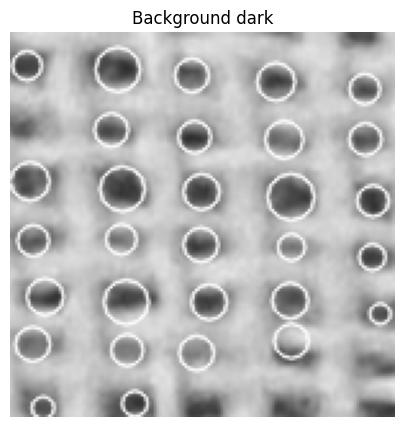

dark
--- 0.7240281105041504 seconds ---


In [ ]:
img = Image.open('/content/drive/MyDrive/Photos_TS/1.jpg')
#gray_img = cv.cvtColor(np.array(img), cv.COLOR_RGB2GRAY)
# fig = plt.figure(figsize=(5, 5))
# plt.imshow(gray_img, cmap='gray')
# plt.show()
start_time = time.time()
white_parameters(img)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
true_por = [292, 420, 123, 92, 230, 115, 220, 210, 232, 174, 555]

In [ ]:
alg1 = [260, 400, 120, 120, 190, 90, 230, 180, 242, 190, 620]
alg2 = [100, 180, 183, 79, 203, 184, 165, 149, 55, 48, 106]
alg3 = [278, 373, 123, 123, 171, 87, 230, 159, 242, 194, 624]

In [ ]:
print("Средняя абсолютная ошибка",sklearn.metrics.mean_absolute_error(true_por, alg1))
print("Средняя квадратичная ошибка", sklearn.metrics.mean_squared_error(true_por, alg1))
print("R^2", sklearn.metrics.r2_score(true_por, alg1))

Средняя абсолютная ошибка 25.363636363636363
Средняя квадратичная ошибка 911.1818181818181
R^2 0.9476110330775649


In [ ]:
print("Средняя абсолютная ошибка",sklearn.metrics.mean_absolute_error(true_por, alg2))
print("Средняя квадратичная ошибка", sklearn.metrics.mean_squared_error(true_por, alg2))
print("R^2", sklearn.metrics.r2_score(true_por, alg2))

Средняя абсолютная ошибка 133.54545454545453
Средняя квадратичная ошибка 32661.363636363636
R^2 -0.8778854725189928


In [ ]:
print("Средняя абсолютная ошибка",sklearn.metrics.mean_absolute_error(true_por, alg3))
print("Средняя квадратичная ошибка", sklearn.metrics.mean_squared_error(true_por, alg3))
print("R^2", sklearn.metrics.r2_score(true_por, alg3))

Средняя абсолютная ошибка 30.818181818181817
Средняя квадратичная ошибка 1417.5454545454545
R^2 0.9184973399958565
